# FeatureHasher and DictVectorizer Comparison
- 사전이나 텍스트 문서와 같이 숫자가 아닌 입력 데이터를 실수 벡터로 표현하는 텍스트 벡터화에 대해 설명

## Load Data

In [1]:
from sklearn.datasets import fetch_20newsgroups

categories = [
    "alt.atheism",
    "comp.graphics",
    "comp.sys.ibm.pc.hardware",
    "misc.forsale",
    "rec.autos",
    "sci.space",
    "talk.religion.misc",
]

print("Loading 20 newsgroups training data")
raw_data, _ = fetch_20newsgroups(subset="train", categories=categories, return_X_y=True)
data_size_mb = sum(len(s.encode("utf-8")) for s in raw_data) / 1e6
print(f"{len(raw_data)} documents - {data_size_mb:.3f}MB")

Loading 20 newsgroups training data
3803 documents - 6.245MB


## Define preprocessing functions

In [2]:
import re


def tokenize(doc):
    """문서에서 토큰 추출

    단어 문자와 일치하는 간단한 정규식을 사용해 문자열을 토큰으로 나누기 위해 토큰을 분해
    원친적인 접근 방식은 CountVectorizer 또는 TfidfVectorizer 참조
    """
    return (tok.lower() for tok in re.findall(r"\w+", doc))


list(tokenize("This is a simple example, isn't it?"))

['this', 'is', 'a', 'simple', 'example', 'isn', 't', 'it']

In [3]:
from collections import defaultdict


def token_freqs(doc):
    """문서에서 토큰을 해당 항목에 매핑하는 딕셔너리를 추출"""

    freq = defaultdict(int)
    for tok in tokenize(doc):
        freq[tok] += 1
    return freq


token_freqs("That is one example, but this is another one")

defaultdict(int,
            {'that': 1,
             'is': 2,
             'one': 2,
             'example': 1,
             'but': 1,
             'this': 1,
             'another': 1})

## DictVectorizer

In [4]:
from time import time

from sklearn.feature_extraction import DictVectorizer

dict_count_vectorizers = defaultdict(list)

t0 = time()
vectorizer = DictVectorizer()
vectorizer.fit_transform(token_freqs(d) for d in raw_data)
duration = time() - t0
dict_count_vectorizers["vectorizer"].append(
    vectorizer.__class__.__name__ + "\non freq dicts"
)
dict_count_vectorizers["speed"].append(data_size_mb / duration)
print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")
print(f"Found {len(vectorizer.get_feature_names_out())} unique terms")

done in 0.472 s at 13.2 MB/s
Found 47928 unique terms


In [5]:
type(vectorizer.vocabulary_)

dict

In [6]:
len(vectorizer.vocabulary_)

47928

In [7]:
vectorizer.vocabulary_["example"]

19145

## FeatureHasher

In [8]:
import numpy as np


def n_nonzero_columns(X):
    """CSR 행렬에서 0이 아닌 값이 하나 이상 있는 열의 수

    피처해셔를 사용할 때 효과적으로 활성화된 피퍼 컬럼의 수를로 열의 수를 계산
    """
    return len(np.unique(X.nonzero()[1]))

In [9]:
from sklearn.feature_extraction import FeatureHasher

t0 = time()
hasher = FeatureHasher(n_features=2**18)
X = hasher.transform(token_freqs(d) for d in raw_data)
duration = time() - t0
dict_count_vectorizers["vectorizer"].append(
    hasher.__class__.__name__ + "\non freq dicts"
)
dict_count_vectorizers["speed"].append(data_size_mb / duration)
print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")
print(f"Found {n_nonzero_columns(X)} unique tokens")

done in 0.283 s at 22.1 MB/s
Found 43873 unique tokens


In [10]:
t0 = time()
hasher = FeatureHasher(n_features=2**22)
X = hasher.transform(token_freqs(d) for d in raw_data)
duration = time() - t0

print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")
print(f"Found {n_nonzero_columns(X)} unique tokens")

done in 0.286 s at 21.8 MB/s
Found 47668 unique tokens


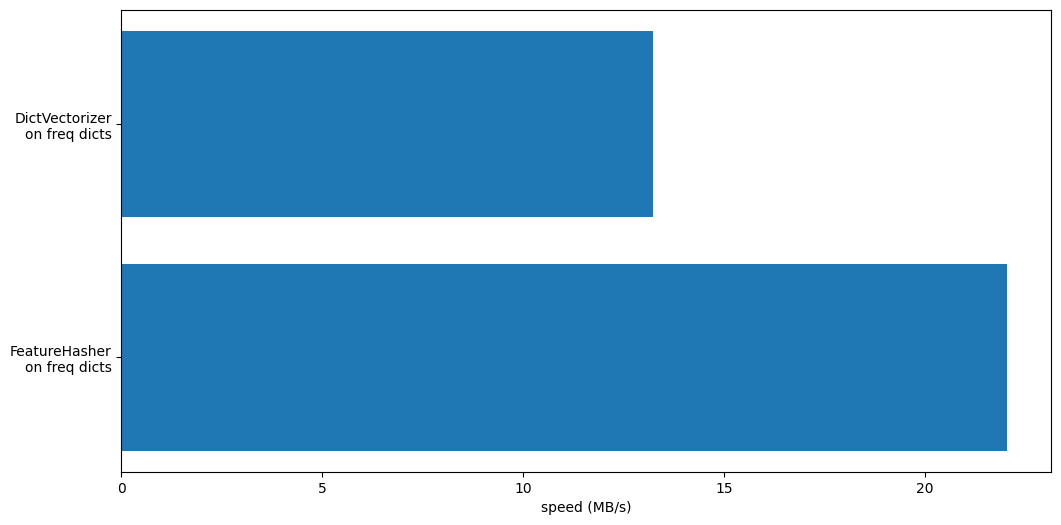

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

y_pos = np.arange(len(dict_count_vectorizers["vectorizer"]))
ax.barh(y_pos, dict_count_vectorizers["speed"], align="center")
ax.set_yticks(y_pos)
ax.set_yticklabels(dict_count_vectorizers["vectorizer"])
ax.invert_yaxis()
_ = ax.set_xlabel("speed (MB/s)")

## Comparison with special purpose text vectorizers

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

t0 = time()
vectorizer = CountVectorizer()
vectorizer.fit_transform(raw_data)
duration = time() - t0
dict_count_vectorizers["vectorizer"].append(vectorizer.__class__.__name__)
dict_count_vectorizers["speed"].append(data_size_mb / duration)
print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")
print(f"Found {len(vectorizer.get_feature_names_out())} unique terms")

done in 0.328 s at 19.0 MB/s
Found 47885 unique terms


In [13]:
from sklearn.feature_extraction.text import HashingVectorizer

t0 = time()
vectorizer = HashingVectorizer(n_features=2**18)
vectorizer.fit_transform(raw_data)
duration = time() - t0
dict_count_vectorizers["vectorizer"].append(vectorizer.__class__.__name__)
dict_count_vectorizers["speed"].append(data_size_mb / duration)
print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")

done in 0.255 s at 24.5 MB/s


## TfidfVectorizer

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

t0 = time()
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(raw_data)
duration = time() - t0
dict_count_vectorizers["vectorizer"].append(vectorizer.__class__.__name__)
dict_count_vectorizers["speed"].append(data_size_mb / duration)
print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")
print(f"Found {len(vectorizer.get_feature_names_out())} unique terms")

done in 0.336 s at 18.6 MB/s
Found 47885 unique terms


## Summary

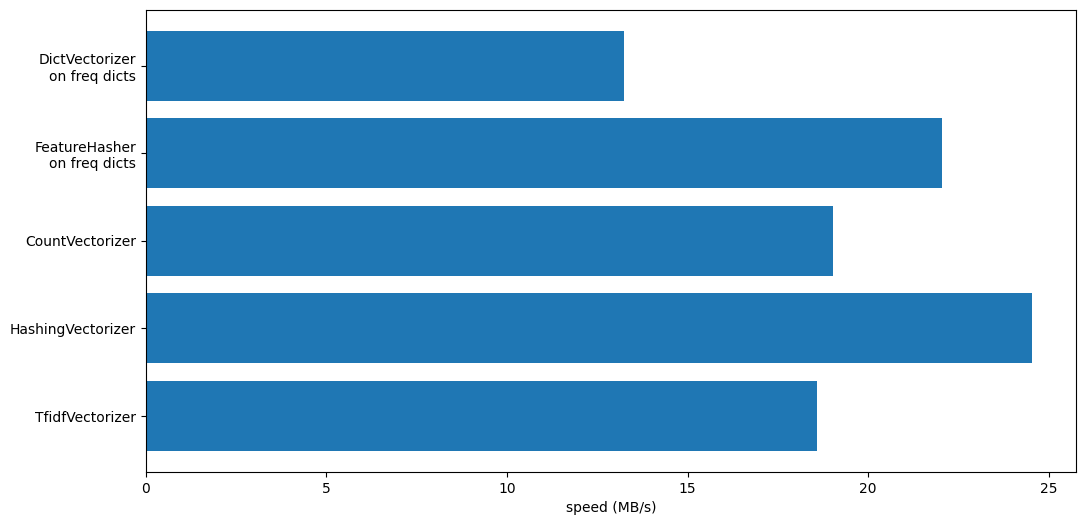

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

y_pos = np.arange(len(dict_count_vectorizers["vectorizer"]))
ax.barh(y_pos, dict_count_vectorizers["speed"], align="center")
ax.set_yticks(y_pos)
ax.set_yticklabels(dict_count_vectorizers["vectorizer"])
ax.invert_yaxis()
_ = ax.set_xlabel("speed (MB/s)")